### Задание
Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение  
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.  
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv
- Использовать приплайны.
- Выполнить поиск лучших параметров / *hyperopt / **optuna
- Кроссвалидация / различные типы проверок.
- Сохранить и загрузить моделль. 
- H20 (если получиться)
- phik

### Анализ задания
- Извлечем из даты 2 новых признака: год и месяц
- Построим матрицу корреляции используя библиотеку phik
- Подберем гиперпараметры регрессионной модели методами библиотеки optuna

### Имплементация
Загрузим данные

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
import optuna
import phik
import joblib

data = pd.read_csv('Walmart.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data.drop(columns=['Date'], inplace=True)

X = data.drop(columns=['Weekly_Sales'])
y = data['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.head())

      Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
4766     34             1        34.11       2.955  127.087677        10.210   
5764     41             0        33.90       2.728  190.974107         7.508   
3151     23             0        36.07       2.805  131.784000         5.892   
4880     35             0        68.90       2.809  136.287426         9.051   
2740     20             0        75.14       2.783  204.357166         7.527   

      Year  Month  
4766  2010     12  
5764  2010     12  
3151  2010      3  
4880  2010      6  
2740  2010      7  


Построим матрицу корреляции

interval columns not set, guessing: ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month']


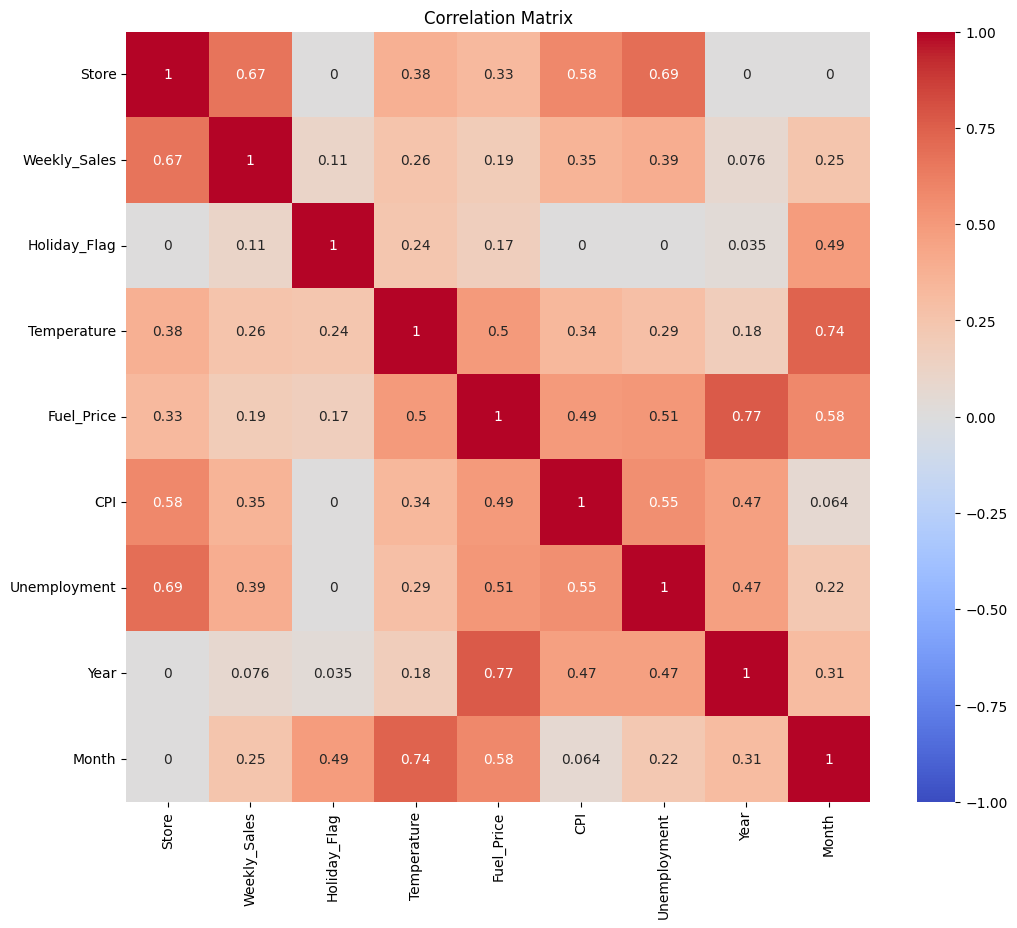

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = phik.phik_matrix(data)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Анализ данных:
- Целевая переменная очень сильно зависит от магазина. В меньшей форме от уровня безработицы и CPI.
- Нет корреляции от праздничных распродаж, что очень странно.  
- Слабая корреляция с годом и ценой на бензин. Однако между этими переменными очень сильная корреляция.  

Подберем лучшие параметры для модели RandomForestRegressor

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import numpy as np

optuna.logging.set_verbosity(optuna.logging.WARNING)

def optimize_model(X_train, y_train):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Holiday_Flag', 'CPI', 'Unemployment']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Store', 'Year', 'Month'])
        ])

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        }
        
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(**params, random_state=0))
        ])
        
        tscv = TimeSeriesSplit(n_splits=3)
        scores = cross_validate(
            model, X_train, y_train, 
            cv=tscv,
            scoring=['r2', 'neg_root_mean_squared_error'],
            n_jobs=-1
        )
        return np.mean(scores['test_neg_root_mean_squared_error'])

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000, show_progress_bar=True)
    
    return study.best_params

best_params = optimize_model(X_train, y_train)
print(best_params)

Best trial: 856. Best value: -151475: 100%|██████████| 1000/1000 [45:33<00:00,  2.73s/it]

{'n_estimators': 230, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}


Обучим модель на лучших параметрах. Сохраним и восстановим из файла модель. Выведем метрики.

In [30]:
def train_and_validate(best_params, X_train, y_train, X_test, y_test):
    final_pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), ['Holiday_Flag', 'CPI', 'Unemployment']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Store', 'Year', 'Month'])
        ])),
        ('regressor', RandomForestRegressor(**best_params, random_state=0))
    ])

    tscv = TimeSeriesSplit(n_splits=3)
    cv_results = cross_validate(
        final_pipeline, X_train, y_train,
        cv=tscv,
        scoring=['r2', 'neg_root_mean_squared_error'],
        return_estimator=True
    )
    
    print("\nРезультаты валидации:")
    print(f"Средний R²: {np.mean(cv_results['test_r2']):.3f}")
    print(f"Средний RMSE: {-np.mean(cv_results['test_neg_root_mean_squared_error']):.2f}")

    final_pipeline.fit(X_train, y_train)

    joblib.dump(final_pipeline, 'best_model.pkl')
    loaded_model = joblib.load('best_model.pkl')
    
    y_pred = loaded_model.predict(X_test)
    
    print("\nМетрики на тестовых данных:")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")

train_and_validate(best_params, X_train, y_train, X_test, y_test)


Результаты валидации:
Средний R²: 0.927
Средний RMSE: 151474.56

Метрики на тестовых данных:
R²: 0.9324
RMSE: 146180.56


### Выводы
- Построили матрицу корреляции и проанализировали данные.
- Построили регрессионную модель на основе RandomForestRegressor.
- Подобрали оптимальные параметры используя библиотеку optuna и Tree-structured Parzen Estimator метод.
- Лучшая модель имеет довольно хорошие параметры. R² стремится к 1, а RMSE мал отнисительно значений целевой переменной.
